In [3]:
import pandas as pd
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Exploration and Modification

In [4]:
# read in dinosaur.csv and modify input so that the list only contains lowercase dinosaur names with no whitespace
dinosaur_csv = pd.read_csv('dinosaur.csv')
dinosaurs = dinosaur_csv['Name'].tolist()
dinosaurs = [d.lower().strip() for d in dinosaurs]
random.shuffle(dinosaurs)
dinosaurs[:5]

['koparion', 'elrhazosaurus', 'dryosaurus', 'amtocephale', 'ngexisaurus']

In [5]:
len(dinosaurs) # number of dinosaur names

1152

In [6]:
chars = sorted(list(set(''.join(dinosaurs)))) # sort letter alphabetically with no repeating letters
stoi = {s:i+1 for i, s in enumerate(chars)} # create a mapping of chars to integers
stoi['.'] = 0 # add special start and end character

itos = {i:s for s,i in stoi.items()} # create a integer to char mapping
vocab_size = len(itos)
print(vocab_size)
print("stoi: ",  stoi)
print("itos: ", itos)

27
stoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [92]:
# dataset splitting into train(80%), dev/validation(10%), test(10%)
# train is used to train parameters
# dev/validation is used to train hyperparameters
# test is used to evaluate the model

g = torch.Generator().manual_seed(42)
train, dev, test = torch.utils.data.random_split(dinosaurs, [0.8, 0.1, 0.1], generator=g)

block_size = 8

# function to create inputs and outputs from dataset
def build_dataset(dataset):
    X, Y = [], []
    for d in dataset:
        context = [0] * block_size # create context 'window'
        for char in d + '.':
            idx = stoi[char] # get current character index

            X.append(context) # add current context to inputs
            Y.append(idx) # add current index to label
            context = context[1:] + [idx] # slide context 'window'
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y
    

# defining training inputs and labels
Xtr, Ytr = build_dataset(train)
print("TRAIN: ", Xtr.shape, Ytr.shape)

# defining validation inputs and labels
Xdev, Ydev = build_dataset(dev)
print("DEV: ", Xdev.shape, Ydev.shape)

# defining test inputs and labels
Xte, Yte = build_dataset(test)
print("TEST: ", Xte.shape, Yte.shape)

TRAIN:  torch.Size([11871, 8]) torch.Size([11871])
DEV:  torch.Size([1465, 8]) torch.Size([1465])
TEST:  torch.Size([1520, 8]) torch.Size([1520])


In [93]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '===>', itos[y.item()])

........ ===> w
.......w ===> u
......wu ===> e
.....wue ===> r
....wuer ===> h
...wuerh ===> o
..wuerho ===> s
.wuerhos ===> a
wuerhosa ===> u
uerhosau ===> r
erhosaur ===> u
rhosauru ===> s
hosaurus ===> .
........ ===> o
.......o ===> s
......os ===> t
.....ost ===> a
....osta ===> f
...ostaf ===> r
..ostafr ===> i


# PyTorch-ified Layers

In [161]:
# linear layer
# -----------------------------------------------------------------------------
class Linear:
    
    # initialize weight and bias (if bias is set to True)
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # using kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    # when module is called, Wx + b will occur
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    # function to return weight and bias tensors
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# -----------------------------------------------------------------------------


# 1 dimensional batch normalization layer
# -----------------------------------------------------------------------------
class BatchNorm1d:
    
    # initialize batch norm parameters
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # backprop parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (running mean and std that trains with momentum)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    # when module is called, batch norm will occur
    def __call__(self, x):
        
        # if training then take the batch mean and variance
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        # otherwise take the mean and variance over the whole dataset
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        # calculate normalization
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        
        # adjust normalization using gamma and beta
        self.out = self.gamma * xhat + self.beta
        
        # if training update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
                
        return self.out
    
    # get batch norm gain and bias
    def parameters(self):
        return [self.gamma, self.beta]
# -----------------------------------------------------------------------------

# non-linear tanh activation function
# -----------------------------------------------------------------------------
class Tanh:
    
    # when module is called, a tanh function will occur
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    # tanh has no parameters so none are returned
    def parameters(self):
        return []
# -----------------------------------------------------------------------------

# character embedding layer
# -----------------------------------------------------------------------------
class Embedding:
    
    #initalize embedding parameters
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    # when this module is called, character embedding will occur
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    # returns all parameters
    def parameters(self):
        return [self.weight]
# -----------------------------------------------------------------------------

# flattening (concatenation) layer
# -----------------------------------------------------------------------------
class FlattenConsecutive:
    # when this module is called, concatenation will occur
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
            
        self.out = x
        return self.out
    
    # no parameters are returned
    def parameters(self):
        return []
# -----------------------------------------------------------------------------

# creating a sequence of layers
# -----------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [162]:
torch.manual_seed(42) # global rng seed

In [198]:
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 68 # number of neurons in hidden layer

# layers of the MLP network
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
# get all parameters (double list comprehension)
print(f'# of parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

# of parameters: 22397


In [199]:
batch_size = 32
max_steps=50000
lossi=[]

for i in range(max_steps):
    
    # create mini-batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01 if i < (max_steps * 0.75) else 0.001 # learning rate decay
    for p in parameters:
        p.data +=  -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

0/50000: 3.2954
10000/50000: 1.0692
20000/50000: 1.3035
30000/50000: 1.2583
40000/50000: 0.9758


In [200]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


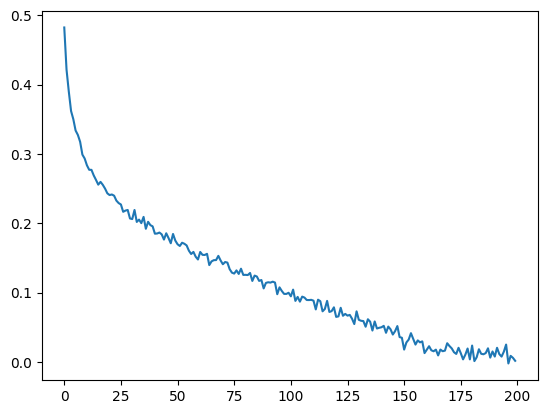

In [201]:
plt.plot(torch.tensor(lossi).view(-1,250).mean(1))

### Performance Log

Original: (block size: 3, 200 hidden neurons, 11.4k parameters) train: 1.07, dev: 2.00\
- block size: 3 --> 8 (20.4k parameters) train: 0.62, dev: 2.41\
- flat ---> hierarchical(20.4k parameters) train: 0.68, dev: 2.31\
- fix bug in batch norm --> (20.4k parameters) train: 0.61, dev: 2.49\

In [135]:
for layer in model.layers:
    layer.training = False

In [136]:
@torch.no_grad()
def dataset_loss(dataset):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[dataset]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y) # use cross entropy as loss function
    print(f'{dataset} loss: {loss.item()}')

dataset_loss('train')
dataset_loss('dev')

train loss: 1.2310081720352173
dev loss: 1.791841745376587


In [137]:
# sample from model
for _ in range(5):
    out = [] # output array
    context = [0] * block_size # context 'window'
    
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item() # get next predicted letter
        context = context[1:] + [idx] # slide the context 'window'
        out.append(idx) # append the new letter to the output
        
        # if the character is '.' then end the word
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

glinoceratis.
sithodon.
olahisauropnyx.
fuktlosaurus.
legvloenis.
